<a href="https://colab.research.google.com/github/aiyufan3/AIPI-XAI-Adversarial-Patches/blob/main/aipi_assignment_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# AIPI 590 - XAI | Assignment #02 | Adversarial-Patches
### Description
This notebook demonstrates the process of creating an adversarial patch to deceive the ResNet34 model, pre-trained on ImageNet. The patch is designed to make the model misclassify a target image, which in this case is an image of a fashion item from the brand. The notebook walks through the steps, from setting up the environment and importing required libraries, to generating the adversarial patch and applying creative components for practical and visual effectiveness. Additionally, the Fast Gradient Sign Method (FGSM) is implemented as an additional adversarial attack to further explore the vulnerabilities of the model.
### Yufan Ai

#### https://colab.research.google.com/gist/aiyufan3/e9ef6b5474106b345647b015e07fc1f7/aipi-assignment-2.ipynb



# Environment Set Up

Create the requirements file and add necessary libraries.

In [ ]:
!pip install pipreqs==0.4.11
!pipreqs --force


  Preparing metadata (setup.py) ... done
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13704 sha256=cdf20f7921186867584e874ad0c59c2aafac9fdff2d6d2cf85bafb4132adeeb0
  Stored in directory: /root/.cache/pip/wheels/fc/ab/d4/5da2067ac95b36618c629a5f93f809425700506f72c9732fac
Successfully built docopt
INFO: Successfully saved requirements file in /content/requirements.txt


##Importing Required Libraries
Importing the necessary libraries and setting up the device

In [ ]:
# Standard libraries
import os
import json
import math
import time
import numpy as np
import scipy.linalg
import requests  # Import requests to handle the image download
from PIL import Image  # Import PIL.Image to handle images
import torchvision.models as models

# Imports for plotting
import matplotlib.pyplot as plt
from IPython.display import set_matplotlib_formats
import matplotlib_inline.backend_inline
from matplotlib.colors import to_rgb
import matplotlib
import seaborn as sns
from io import BytesIO

# Set matplotlib formats
matplotlib_inline.backend_inline.set_matplotlib_formats('svg', 'pdf')  # Updated to avoid deprecation warning

# Configure Matplotlib
matplotlib.rcParams['lines.linewidth'] = 2.0
sns.set()

# Progress bar
from tqdm.notebook import tqdm

# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim

# Torchvision
import torchvision
from torchvision.datasets import CIFAR10
from torchvision import transforms

# Fetching the device that will be used throughout this notebook
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


## Load Pre-trained ResNet34 Model
Load the ResNet34 model pre-trained on ImageNet.

In [ ]:
model = models.resnet34(weights='IMAGENET1K_V1').to(device)
model.eval()  # Set the model to evaluation mode
for param in model.parameters():
    param.requires_grad = False

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:01<00:00, 57.1MB/s]


# Input Image
Load the cloth brand image from Viewin and apply necessary transformations.

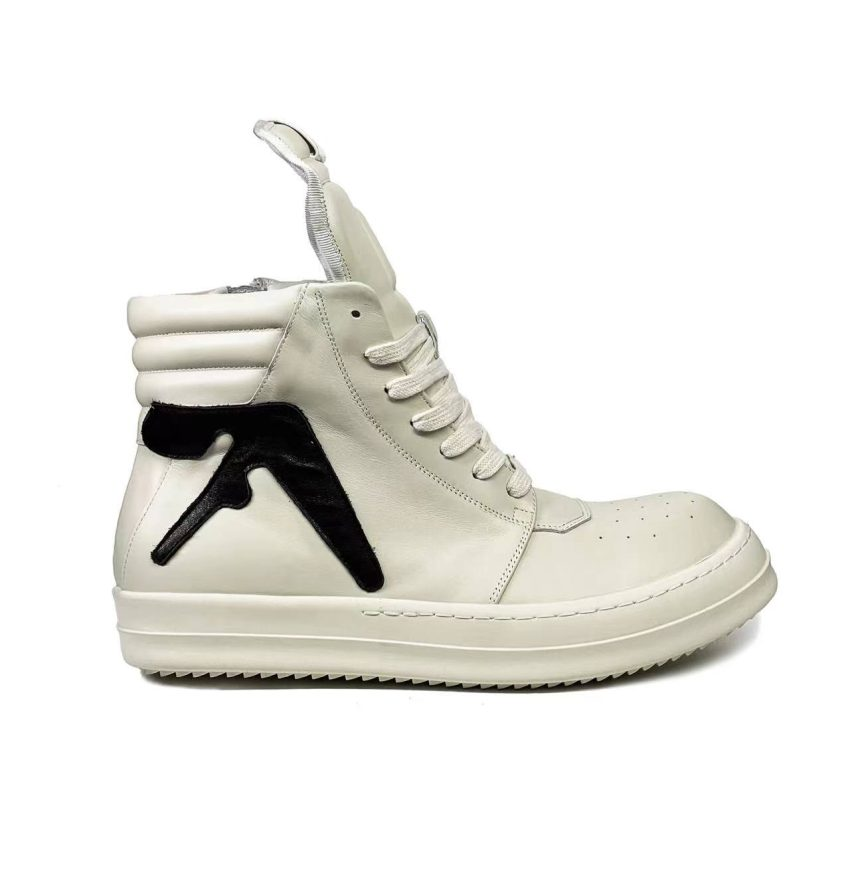

In [ ]:
# Load and preprocess the image
image_url = "https://viewin-online.com/wp-content/uploads/2024/05/19001716090571_.pic_-850x869.jpg" #change the url for further using
response = requests.get(image_url)
img = Image.open(BytesIO(response.content))

# Transformations to match the ImageNet format
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # ResNet34 expects 224x224
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

input_image = transform(img).unsqueeze(0).to(device)
display(img)

# Adversarial Patch

In [ ]:
# Initialize the patch with random noise
patch_size = (53, 53)  # Adjust size to 53 for later design use
patch = nn.Parameter(torch.rand(3, patch_size[0], patch_size[1], device=device))

def apply_patch(image, patch, position=(10, 10)):
    patched_image = image.clone()
    patched_image[0, :, position[0]:position[0]+patch_size[0], position[1]:position[1]+patch_size[1]] = patch
    return patched_image

## Define the Adversarial Loss and Optimize the Patch
Define the loss function to target a specific class - sweatshirt from ImageNet and optimize the patch.

In [ ]:
# Define target class ("swearshirt" class index is 842 from ImageNet.txt)
target_class = 842

# Convert target class to a tensor
target_label = torch.tensor([target_class], dtype=torch.long, device=device)

# Optimization settings
optimizer = optim.Adam([patch], lr=0.1)
criterion = nn.CrossEntropyLoss()

# Training loop
num_iterations = 100 #set the iterations time to 100 for patch
for i in tqdm(range(num_iterations)):
    optimizer.zero_grad()
    patched_image = apply_patch(input_image, patch, position=(90, 120))
    output = model(patched_image)
    loss = criterion(output, target_label)
    loss.backward()
    optimizer.step()
    if i % 10 == 0:
        print(f"Iteration {i}: Loss = {loss.item()}")

# After optimization, the patch is ready
final_patch = patch.detach()


  0%|          | 0/100 [00:00<?, ?it/s]

Iteration 0: Loss = 12.858012199401855
Iteration 10: Loss = 4.855708122253418
Iteration 20: Loss = 1.616593837738037
Iteration 30: Loss = 0.277009516954422
Iteration 40: Loss = 0.08465517312288284
Iteration 50: Loss = 0.03798472136259079
Iteration 60: Loss = 0.021876800805330276
Iteration 70: Loss = 0.015151411294937134
Iteration 80: Loss = 0.011716481298208237
Iteration 90: Loss = 0.009519894607365131


## Visualize

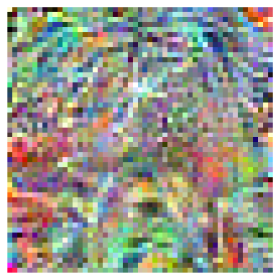

In [ ]:
# Visualize the patch
def show_image(img_tensor):
    img = img_tensor.detach().squeeze(0).cpu().numpy().transpose(1, 2, 0)
    img = np.clip(img * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406], 0, 1)
    plt.imshow(img)
    plt.axis('off')
    plt.show()


# Display the patch
show_image(final_patch.unsqueeze(0))

# Creative Component
For this part, to create a more interesting image, firstly add the adversarial patch into the original shoes input image to make it have a new design.

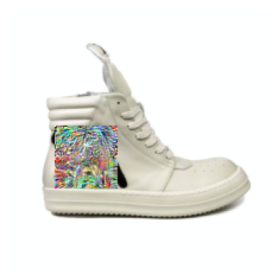

In [ ]:

# Position on the shoes related to the design
patched_image = apply_patch(input_image, patch, position=(100, 40))
# Display patched image
show_image(patched_image)

##FGSM Implement
Use the Fast Gradient Sign Method (FGSM) as an additional adversarial attack.

In [ ]:
def fgsm_attack(patched_image, epsilon, data_grad):
    # Collect gradients
    sign_data_grad = data_grad.sign()
    # Create the perturbed image by adjusting each pixel of the input image and adding clipping
    perturbed_image = patched_image + epsilon * sign_data_grad
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    return perturbed_image


Apply FGSM Attack to the Patched Image

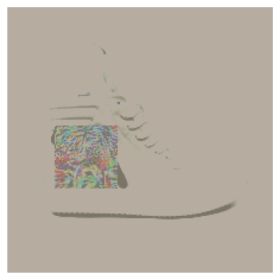

In [ ]:
def apply_fgsm_attack(model, image, target_label, epsilon=0.03):
    new_image1 = image.clone().detach().requires_grad_(True)

    # Forward pass
    output = model(new_image1)
    loss = F.cross_entropy(output, target_label)

    model.zero_grad()

    # Backward pass
    loss.backward()

    # Collect the gradients of the input image
    data_grad = new_image1.grad.data

    # FGSM attack
    perturbed_image = fgsm_attack(new_image1, epsilon, data_grad)

    return perturbed_image

# Apply
perturbed_image = apply_fgsm_attack(model, patched_image, target_label)

show_image(perturbed_image)


# Reference
[1] Duke AI XAI. "Adversarial Attacks Example Notebook." GitHub Repository. Available at: https://github.com/AIPI-590-XAI/Duke-AI-XAI/blob/main/adversarial-ai-example-notebooks/adversarial_attacks.ipynb

